# Scaled Dot-Product Attention: Ungraded Lab

The 2017 paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) introduced the Transformer model and scaled dot-product attention, sometimes also called QKV (**Q**ueries, **K**eys, **V**alues) attention. Since then, Transformers have come to dominate large-scale natural language applications. Scaled dot-product attention can be used to improve seq2seq models as well. In this ungraded lab, you'll implement a simplified version of scaled dot-product attention and replicate word alignment between English and French, as shown in [Bhadanau, et al. (2014)](https://arxiv.org/abs/1409.0473).

The Transformer model learns how to align words in different languages. You won't be training any weights here, so instead you will use [pre-trained aligned word embeddings from here](https://fasttext.cc/docs/en/aligned-vectors.html). Run the cell below to load the embeddings and set up the rest of the notebook.

This is a practice notebook, where you can train writing your code. All of the solutions are provided at the end of the notebook.

In [1]:
# Import the libraries
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the word2int dictionaries
with open("./data/word2int_en.pkl", "rb") as f:
    en_words = pickle.load(f)
    
with open("./data/word2int_fr.pkl", "rb") as f:
    fr_words = pickle.load(f)

# Load the word embeddings
en_embeddings = np.load("./data/embeddings_en.npz")["embeddings"]
fr_embeddings = np.load("./data/embeddings_fr.npz")["embeddings"]

In [17]:
print(en_words["the"])
print(len(en_words.keys()))
print(en_words.items())
type(en_words)

2
10000
dict_items([(',', 0), ('.', 1), ('the', 2), ('</s>', 3), ('of', 4), ('-', 5), ('in', 6), ('and', 7), ("'", 8), (')', 9), ('(', 10), ('to', 11), ('a', 12), ('is', 13), ('was', 14), ('on', 15), ('s', 16), ('for', 17), ('as', 18), ('by', 19), ('that', 20), ('it', 21), ('with', 22), ('from', 23), ('at', 24), ('he', 25), ('this', 26), ('be', 27), ('i', 28), ('an', 29), ('utc', 30), ('his', 31), ('not', 32), ('–', 33), ('are', 34), ('or', 35), ('talk', 36), ('which', 37), ('also', 38), ('has', 39), ('were', 40), ('but', 41), ('have', 42), ('#', 43), ('one', 44), ('rd', 45), ('new', 46), ('first', 47), ('page', 48), ('no', 49), ('you', 50), ('they', 51), ('had', 52), ('article', 53), ('t', 54), ('who', 55), ('?', 56), ('all', 57), ('their', 58), ('there', 59), ('been', 60), ('made', 61), ('its', 62), ('people', 63), ('may', 64), ('after', 65), ('%', 66), ('other', 67), ('should', 68), ('two', 69), ('score', 70), ('her', 71), ('can', 72), ('would', 73), ('more', 74), ('if', 75), ('she'

dict

In [18]:
# Define some helper functions

def tokenize(sentence, token_mapping):
    tokenized = []
    
    for word in sentence.lower().split(" "):
        try:
            tokenized.append(token_mapping[word])
        except KeyError:
            # Using -1 to indicate an unknown word
            tokenized.append(-1)
        
    return tokenized


def embed(tokens, embeddings):
    embed_size = embeddings.shape[1]
    
    output = np.zeros((len(tokens), embed_size))
    for i, token in enumerate(tokens):
        if token == -1:
            output[i] = np.zeros((1, embed_size))
        else:
            output[i] = embeddings[token]
            
    return output

The scaled-dot product attention consists of two matrix multiplications and a softmax scaling as shown in the diagram below from [Vaswani, et al. (2017)](https://arxiv.org/abs/1706.03762). It takes three input matrices, the queries, keys, and values.

![scaled-dot product attention diagram](./images/attention.png)

Mathematically, this is expressed as

$$ 
\large \mathrm{Attention}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)V
$$

where $Q$, $K$, and $V$ are the queries, keys, and values matrices respectively, and $d_k$ is the dimension of the keys. In practice, Q, K, and V all have the same dimensions. This form of attention is faster and more space-efficient than what you implemented before since it consists of only matrix multiplications instead of a learned feed-forward layer.

Conceptually, the first matrix multiplication is a measure of the similarity between the queries and the keys. This is transformed into weights using the softmax function. These weights are then applied to the values with the second matrix multiplication resulting in output attention vectors. Typically, decoder states are used as the queries while encoder states are the keys and values.

### Exercise 1
Implement the softmax function with Numpy and use it to calculate the weights from the queries and keys. Assume the queries and keys are 2D arrays (matrices). Note that since the dot-product of Q and K will be a matrix, you'll need to calculate softmax over a specific axis. See the end of the notebook for solutions.

In [21]:
def softmax(x, axis=0):    
    """ Calculate softmax function for an array x

        axis=0 calculates softmax across rows which means each column sums to 1 
        axis=1 calculates softmax across columns which means each row sums to 1
    """
    # Replace pass with your code.
    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    sum_e_x = np.sum(e_x, axis=axis, keepdims=True)
    return e_x / sum_e_x

def calculate_weights(queries, keys):
    """ Calculate the weights for scaled dot-product attention"""
    # Replace None with your code.
    dk = keys.shape[-1]
    dot = np.dot(queries, keys.T) / np.sqrt(dk)
    weights = softmax(dot, axis=1)
    
    assert np.allclose(weights.sum(axis=1), 1, atol=1e-6), "Each row in weights must sum to 1"
    
    # Replace pass with your code.
    return weights

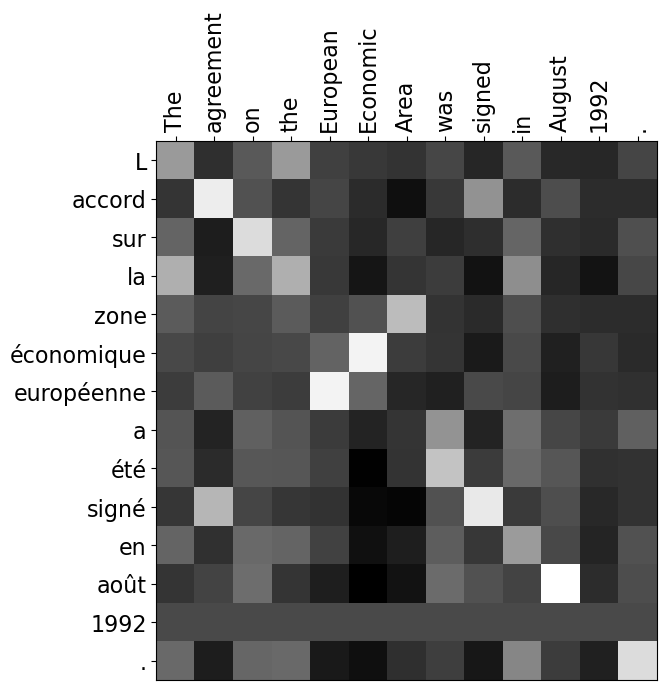

In [22]:
# Tokenize example sentences in English and French, then get their embeddings
sentence_en = "The agreement on the European Economic Area was signed in August 1992 ."
tokenized_en = tokenize(sentence_en, en_words)
embedded_en = embed(tokenized_en, en_embeddings)

sentence_fr = "L accord sur la zone économique européenne a été signé en août 1992 ."
tokenized_fr = tokenize(sentence_fr, fr_words)
embedded_fr = embed(tokenized_fr, fr_embeddings)

# These weights indicate alignment between words in English and French
alignment = calculate_weights(embedded_fr, embedded_en)

# Visualize weights to check for alignment
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(alignment, cmap='gray')
ax.xaxis.tick_top()
ax.set_xticks(np.arange(alignment.shape[1]))
ax.set_xticklabels(sentence_en.split(" "), rotation=90, size=16);
ax.set_yticks(np.arange(alignment.shape[0]));
ax.set_yticklabels(sentence_fr.split(" "), size=16);

If you implemented the weights calculations correctly, the alignment matrix should look like this:

![alignment visualization](./images/alignment.png)

This is a demonstration of alignment where the model has learned which words in English correspond to words in French. For example, the words *signed* and *signé* have a large weight because they have the same meaning. Typically, these alignments are learned using linear layers in the model, but you've used pre-trained embeddings here.

### Exercise 2
Complete the implementation of scaled dot-product attention using your `calculate_weights` function (ignore the mask).

In [24]:
def attention_qkv(queries, keys, values):
    """ Calculate scaled dot-product attention from queries, keys, and values matrices """
    
    # Replace pass with your code.
    final_matmul = np.dot(calculate_weights(queries,keys),values)
    return final_matmul


attention_qkv_result = attention_qkv(embedded_fr, embedded_en, embedded_en)

print(f"The shape of the attention_qkv function is {attention_qkv_result.shape}")
print(f"Some elements of the attention_qkv function are \n{attention_qkv_result[0:2,:10]}")

The shape of the attention_qkv function is (14, 300)
Some elements of the attention_qkv function are 
[[-0.04039161 -0.00275749  0.00389873  0.04842744 -0.02472726  0.01435613
  -0.00370253 -0.0619686  -0.00206159  0.01615228]
 [-0.04083253 -0.00245985  0.00409068  0.04830341 -0.02479128  0.01447497
  -0.00355203 -0.06196036 -0.00241327  0.01582606]]


**Expected output**

The shape of the attention_qkv function is `(14, 300)`

Some elements of the attention_qkv function are 
```python
[[-0.04039161 -0.00275749  0.00389873  0.04842744 -0.02472726  0.01435613
  -0.00370253 -0.0619686  -0.00206159  0.01615228]
 [-0.04083253 -0.00245985  0.00409068  0.04830341 -0.02479128  0.01447497
  -0.00355203 -0.06196036 -0.00241327  0.01582606]]
```

## Solutions

```python
def softmax(x, axis=0):
    """ Calculate softmax function for an array x
    
        axis=0 calculates softmax across rows which means each column sums to 1 
        axis=1 calculates softmax across columns which means each row sums to 1
    """
    y = np.exp(x) 
    return y / np.expand_dims(np.sum(y, axis=axis), axis)

def calculate_weights(queries, keys):
    """ Calculate the weights for scaled dot-product attention"""
    dot = np.matmul(queries, keys.T)/np.sqrt(keys.shape[1])
    weights = softmax(dot, axis=1)
    
    assert weights.sum(axis=1)[0] == 1, "Each row in weights must sum to 1"
    
    return weights

def attention_qkv(queries, keys, values):
    """ Calculate scaled dot-product attention from queries, keys, and values matrices """
    weights = calculate_weights(queries, keys)
    return np.matmul(weights, values)
```